# Статистический анализ данных популярного сервиса аренды самокатов GoFast

**Описание и цели проекта**

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

- без подписки

 * абонентская плата отсутствует;
 * стоимость одной минуты поездки — 8 рублей;
 * стоимость старта (начала поездки) — 50 рублей;

- с подпиской Ultra

 * абонентская плата — 199 рублей в месяц;
 * стоимость одной минуты поездки — 6 рублей;
 * стоимость старта — бесплатно.
 
 **Описание данных:**

В предоставленных данных есть информация о пользователях, их поездках и подписках.

*Пользователи — файл users_go.csv*

*Поездки — файл rides_go.csv*

*Подписки — файл subscriptions_go.csv*


#### Шаг 1. Загрузка данных

Импортируем все необходимые библиотеки для дальнейшей работы с данными:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from math import sqrt
from scipy.stats import binom, norm

Считаем CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы.

Первый датафрейм *Пользователи — users_go.csv*

In [2]:
users_data = pd.read_csv('/datasets/users_go.csv')
users_data.to_csv('users_go.csv', index=False) 

Второй датафрейм *Поездки — rides_go.csv*

In [3]:
rides_data = pd.read_csv('/datasets/rides_go.csv')
rides_data.to_csv('rides_go.csv', index=False)

Третий датафрейм *Подписки — subscriptions_go.csv*

In [4]:
sub_data = pd.read_csv('/datasets/subscriptions_go.csv')
sub_data.to_csv('subscriptions_go.csv', index=False) 

Выведем первые строки датафреймов и общую информацию.

Первый датафрейм о пользователях:

In [5]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Второй датафрейм о поездках:

In [6]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Третий датафрейм о подписках:

In [7]:
sub_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


 Итак, мы загрузили три датафрейма: первый содержит информацию о пользователях,второй об их поездках (самый большой датафрейм), и третий о подписках и условиях оплаты. По общей информации понятно, что есть только 1 столбец из 1 датафрейма с некорреткным типом данных - это столбец с датой поездки во 2ом датафрейме. 

#### Шаг 2. Предобработка данных

##### Приведем столбец date из датафрейма rides_data к типу даты pandas:

In [8]:
rides_data['date'] = pd.to_datetime(rides_data['date'], format='%Y-%m-%d')

Проверим преобразование:

In [9]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### Создадим новый столбец с номером месяца на основе столбца date из датафрейма rides_data:

In [10]:
rides_data['month'] = rides_data['date'].dt.month
rides_data.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


##### Проверим наличие пропущенных значений и дубликатов в датафреймах и обработаем их, если такие значения присутствуют.

В общей информации при вызове метода info() было понятно, что пропущенных значений нет ( общее кол-во строк совпадает с кол-вом ненулевых значений в столбцах), но проверим еще раз методом isna(): 

In [11]:
users_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [12]:
rides_data.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [13]:
sub_data.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Да, пропусков нет. Перейдем к поиску дубликатов. Найдем целые строки-дубликаты и избавимся от них c заменой индексов строк.

In [14]:
users_data.duplicated().sum()

31

In [15]:
users_data = users_data.drop_duplicates().reset_index(drop=True)

In [16]:
users_data.duplicated().sum()

0

Также поступим со 2ым и 3им датафреймами:

In [17]:
rides_data.duplicated().sum()

0

In [18]:
sub_data.duplicated().sum()

0

Дубликаты во 2ом и 3ем датафреймах не обнаружены

Ну и можно проверить неявные дубликаты в 1ом датафрейме users_data в именах - вдруг имена на английском записаны или с маленькой буквы, проверим:

In [19]:
users_data['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

Все выглядит правильно. В других датафреймах нет таких данных, по которым могут быть неявные дубликаты.

*Итак, по шагу 2 выполнена предобработка данных:*

* столбцы приведены к правильному типу данных
* создан новый столбец с номером месяца
* проверены пропущенные значения и удалены дубликаты

#### Шаг 3. Исследовательский анализ данных

Опишим и визуализируем общую информацию о пользователях и поездках:

* 3.1 частота встречаемости городов;
* 3.2 соотношение пользователей с подпиской и без подписки;
* 3.3 возраст пользователей;
* 3.4 расстояние, которое пользователь преодолел за одну поездку;
* 3.5 продолжительность поездок.

##### Частота встречаемости городов

Создадим сводную таблицу с группировкой по городам для дальнейшей визуализации и нам понадобится только 1 столбец, переименуем его в count:

In [20]:
cities_count = users_data.pivot_table(index='city', values='user_id', aggfunc='count')
cities_count = cities_count.rename(columns={'user_id': 'count'})
cities_count.sort_values(by='count')

,count
city,
Москва,168
Тюмень,180
Омск,183
Сочи,189
Краснодар,193
Ростов-на-Дону,198
Екатеринбург,204
Пятигорск,219


Строим столбчатый график, сортируя для наглядности по возрастанию количества пользователей в городах.

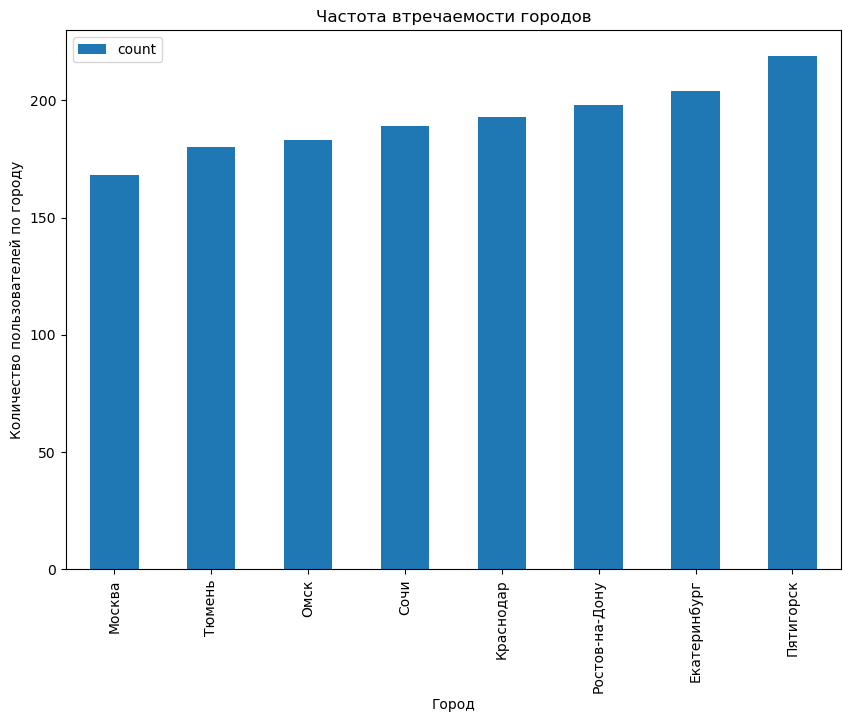

In [21]:
cities_count.sort_values(by='count').plot(y='count', kind='bar', figsize=(10, 7))
plt.xlabel('Город')
plt.ylabel('Количество пользователей по городу')
plt.title('Частота втречаемости городов')

plt.show()

Ого) в Москве самое маленькое кол-во пользователей самокатов. В Пятигорске - самое высокое!

##### Cоотношение пользователей с подпиской и без подписки

Построим круговую диаграмму для наглядности распределения по долям:

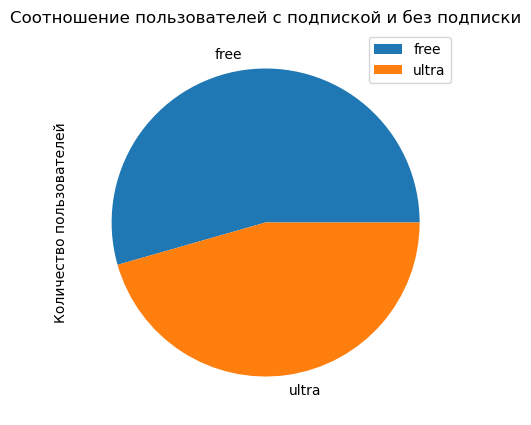

In [22]:
(
    users_data
    .pivot_table(index='subscription_type', aggfunc='count')
    .plot(y='age', kind='pie', figsize=(5, 5))
)
plt.ylabel('Количество пользователей')
plt.title('Соотношение пользователей с подпиской и без подписки')

plt.show()

Пользователей без подписки больше половины.Интересно, сколько это в процентах?

Посмотрим на кол-во пользователей с подпиской (ultra) и без подписки (free):

In [23]:
users_data.pivot_table(index='subscription_type', aggfunc='count')

,age,city,name,user_id
subscription_type,,,,
free,835,835,835,835
ultra,699,699,699,699


Доля в % пользователей без подписки:

In [24]:
free_percent = round(100*835/(835+699), 1)
free_percent

54.4

Доля в % пользователей с подпиской:

In [25]:
ultra_percent = round(100*699/(835+699), 1)
ultra_percent

45.6

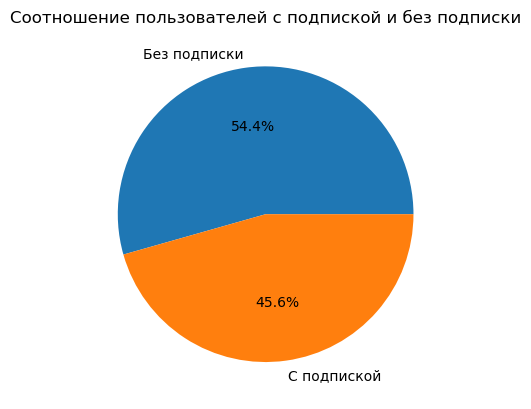

In [26]:
sizes = [54.4, 45.6]
labels = ['Без подписки', 'С подпиской']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

##### Возраст пользователей

Построим на распределение кол-ва пользователей сервиса по возрастам.

In [27]:
users_data.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Построим столбчатый график распределения по возрасту:

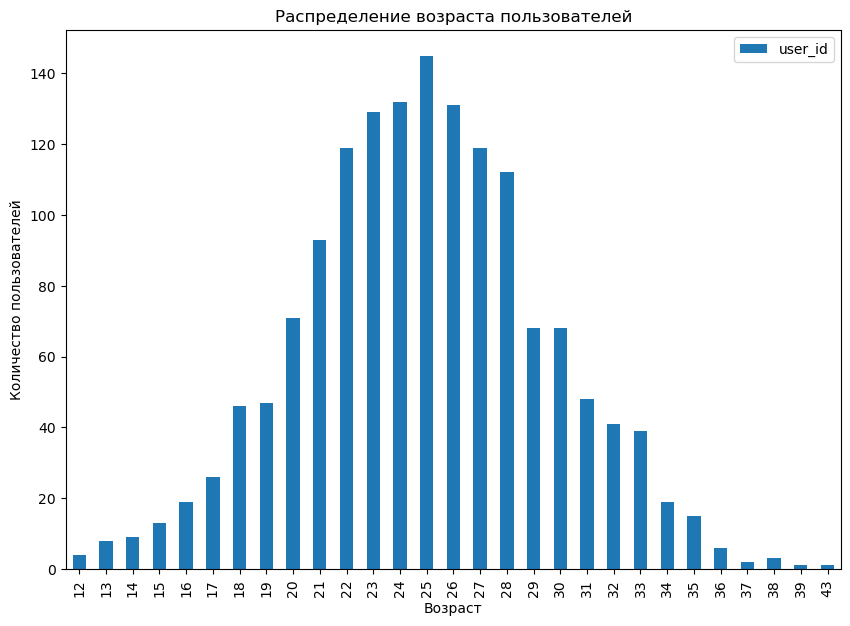

In [28]:
(
    users_data
    .pivot_table(index='age', values='user_id', aggfunc='count')
    .plot(kind='bar', figsize=(10, 7))
)
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Распределение возраста пользователей')

plt.show()

Получилось нормальное распределение с модой 25, без выбросов и аномалий, с плавным снижением пользователей с возрастом менее и более 25 лет. Также посмотрим основные параметры распределения данных по возрасту методом describe():

In [29]:
users_data['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Мода и медиана - это возраст 25 лет. Среднее также близко к 25 годам (24,9 лет). Половина пользователей, находящихся вокруг среднего возраста (межквартильный размах) имеет возраст от 22 до 28 лет.

##### Расстояние, которое пользователь преодолел за одну поездку

Построим гистограмму с распределением расстояний поездок.

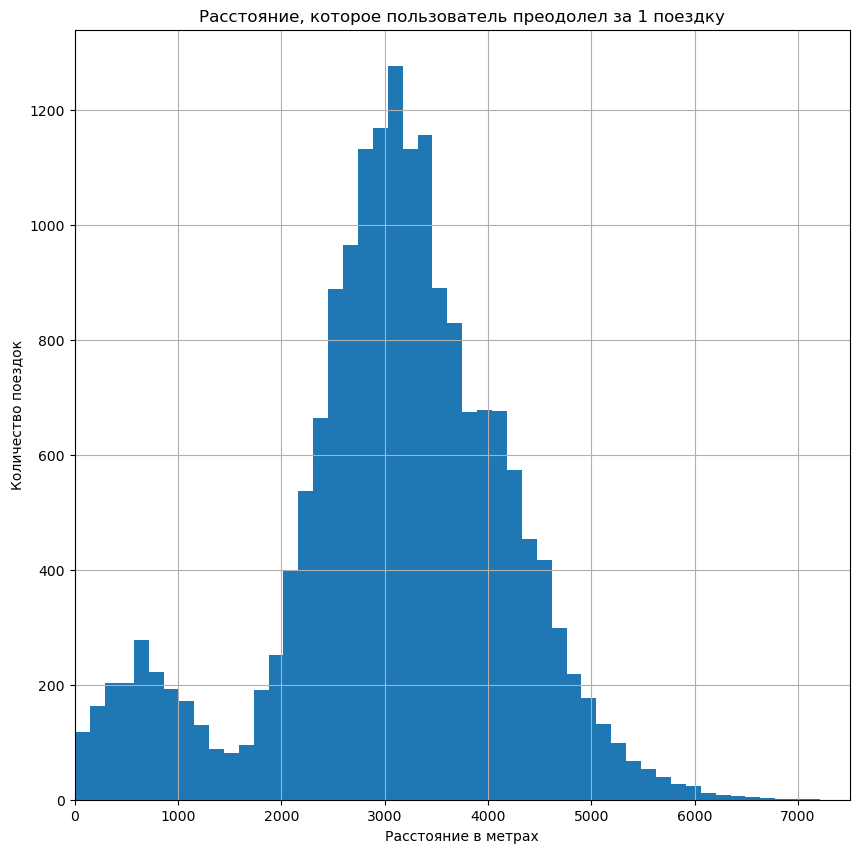

In [30]:
rides_data['distance'].hist(bins=50, figsize=(10,10))
plt.xlim(0,7500)
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние, которое пользователь преодолел за 1 поездку')
plt.show()

Видно, что распределение нормальное с модой около 3000 м. Но также есть пик с нормальным распредлением примерно на 700 м. Посмотрим конкретные значения в описании данных:

In [31]:
rides_data['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Минимальное значение слишком малое для поездки (0.8 м). Стоит посмотреть выбросы на диаграмме размаха.

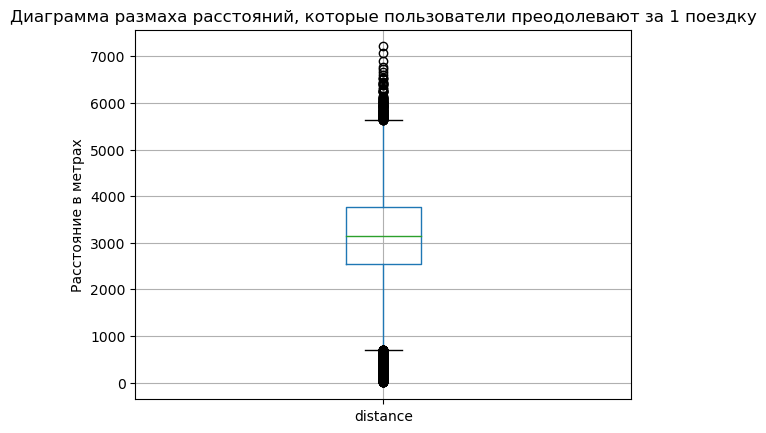

In [32]:
rides_data.boxplot('distance')
plt.ylabel('Расстояние в метрах')
plt.title('Диаграмма размаха расстояний, которые пользователи преодолевают за 1 поездку')
plt.show()

Да, выбросы действительно есть. Как и в больших расстояниях (примерно > 5500 м), так и маленьких (примерно < 800 м). Думаю, выбросы в больших расстояниях имеют право на существование, т.к. такие поездки возможны действительно. Совсем маленькие расстояния (например, менее < 100 м) - возможно связаны с остановкой поездки по каким-либо непредвиденным причинам. Удалять такие данные не будем,т.к. оплата за эти поездки была проведена, это реальные данные и их удаление может привести к потере важной информации и дальнейшему искажению исследования.

##### Продолжительность поездок

In [33]:
rides_data.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Построим график распределения продолжительности поездок и описание данных:

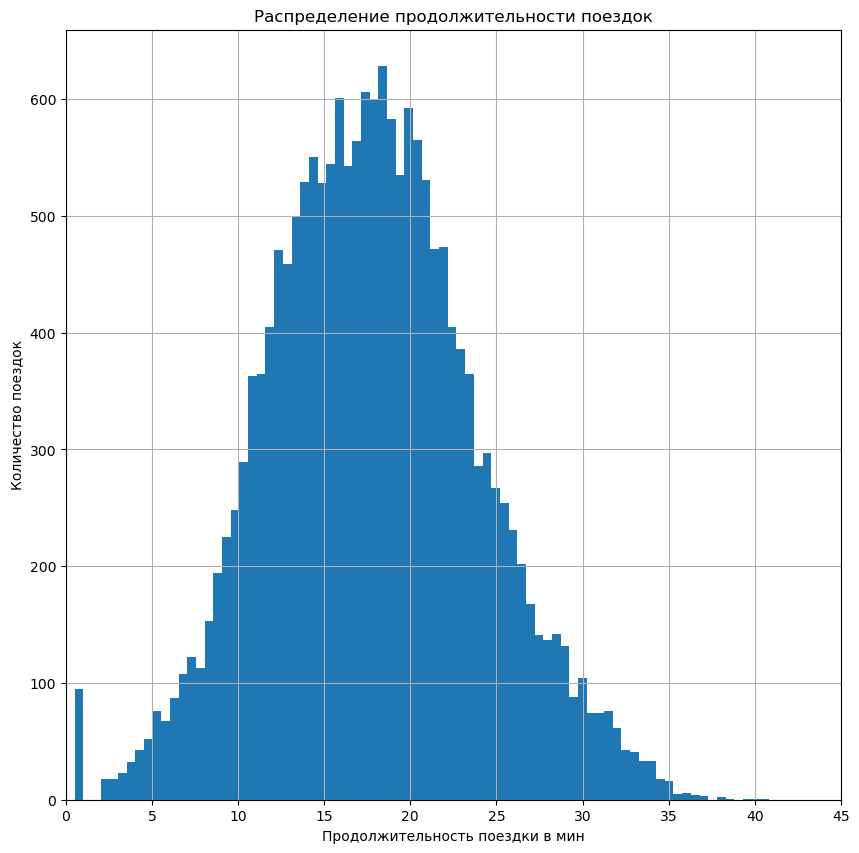

In [34]:
rides_data['duration'].hist(bins=80, figsize=(10,10));
plt.xlim(0,45)
plt.xlabel('Продолжительность поездки в мин')
plt.ylabel('Количество поездок')
plt.title('Распределение продолжительности поездок')
plt.show()

In [35]:
rides_data['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Видим нормальное распределение с медианой на 17.7 мин, что соответсвует центру на графике. Межквартильный размах данных составляет от 13,6 мин до 21,7 мин.  Но также на графике выделяются примерно 100 поездок с продолжительностью примерно 1-2 мин. Построим диаграмму размаха, посмотрим на выбросы

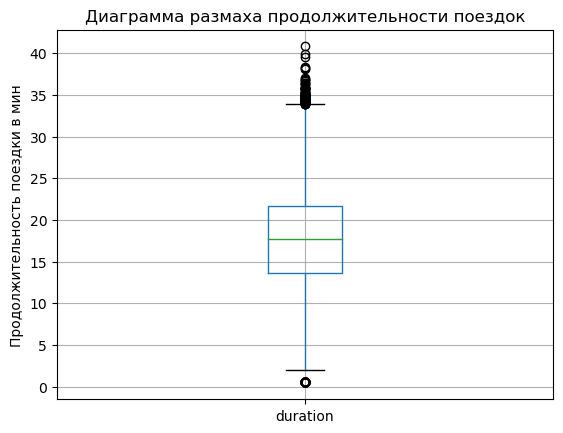

In [61]:
rides_data.boxplot('duration')
plt.ylabel('Продолжительность поездки в мин')
plt.title('Диаграмма размаха продолжительности поездок')
plt.show()

Да, по диаграмме размаха они в зоне выбросов. Но также, как и в предыдущем шаге, удалять такие данные не будем, т.к. оплата за эти поездки была проведена, это реальные данные и их удаление может привести к потере важной информации и дальнейшему искажению исследования.

*Итак, по шагу 3 проведен исследовательский анализ данных - описана и визуализирована общая информация о пользователях и поездках:*

* 3.1 частота встречаемости городов;
* 3.2 соотношение пользователей с подпиской и без подписки;
* 3.3 возраст пользователей;
* 3.4 расстояние, которое пользователь преодолел за одну поездку;
* 3.5 продолжительность поездок.

#### Шаг 4. Объединение данных

##### Объединим данные о пользователях, поездках и подписках в один датафрейм

Для этого воспользуемся методом merge()

In [37]:
users_rides_data = users_data.merge(rides_data, on='user_id', how='left')
total_df = users_rides_data.merge(sub_data, on='subscription_type', how='left')
total_df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Проверю, правильно ли сработало объединение: кол-во полученных строк объединенной таблицы должно соотвествовать кол-ву строк таблицы rides_data с данными о поездках (т.к. именно в этой таблице больше всего данных):

In [38]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


In [39]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB


Да, 17895 строк - все правильно.

##### Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:

* c данными о пользователях без подписки;
* с данными о пользователях с подпиской.

Создаем датафрейм с данными о пользователях без подписки:

In [40]:
total_free = total_df.query('subscription_type == "free"').reset_index(drop=True)
total_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


Создаем датафрейм с данными о пользователях с подпиской:

In [41]:
total_ultra = total_df.query('subscription_type == "ultra"').reset_index(drop=True)
total_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


##### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

Построим график рассеяния - зависимость расстояния от времени поездки **для пользователей без подписки.**

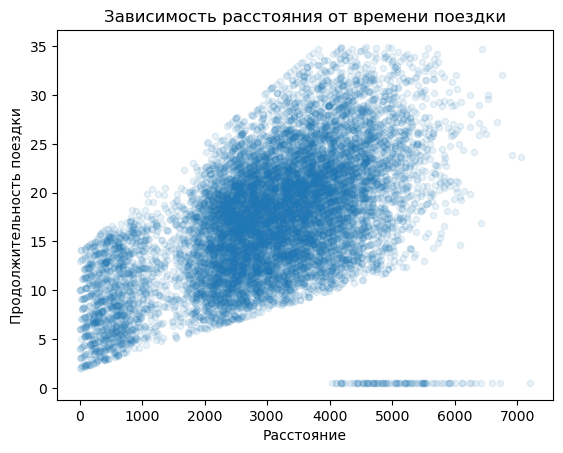

In [42]:
total_free.plot(x='distance', y='duration', kind='scatter', alpha=0.1, title='Зависимость расстояния от времени поездки')
plt.xlabel('Расстояние')
plt.ylabel('Продолжительность поездки')
plt.show();

Видно, что в целом данные коррелируют, но нельзя сказать, что однозначно. Посчитаем корреляцию:

In [43]:
total_free['distance'].corr(total_free['duration'])

0.5557785138794203

Корреляция есть, но не очень большая. Значит, не всегда время поездки прямо пропорционально расстоянию. 

Построим график зависимости расстояния от времени поездки **для пользователей с подпиской.**

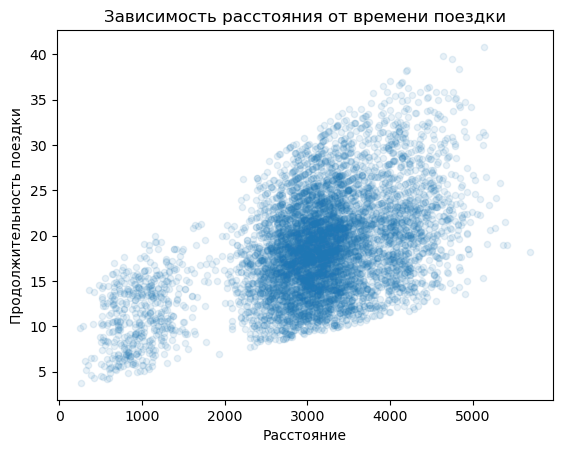

In [44]:
total_ultra.plot(x='distance', y='duration', kind='scatter', alpha=0.1, title='Зависимость расстояния от времени поездки');
plt.xlabel('Расстояние')
plt.ylabel('Продолжительность поездки')
plt.show();

Корреляция видна, но кажется, что она даже меньше, чем в предыдущем случае. Посчитаем ее:

In [45]:
total_ultra['distance'].corr(total_ultra['duration'])

0.49334059824854526

В случаях с подпиской прямая зависимость продолжительности поездки от расстояния меньше, чем в случаях без подписки.

Построим еще гистограмму с распределением продолжительности поездок (с подпиской и без):

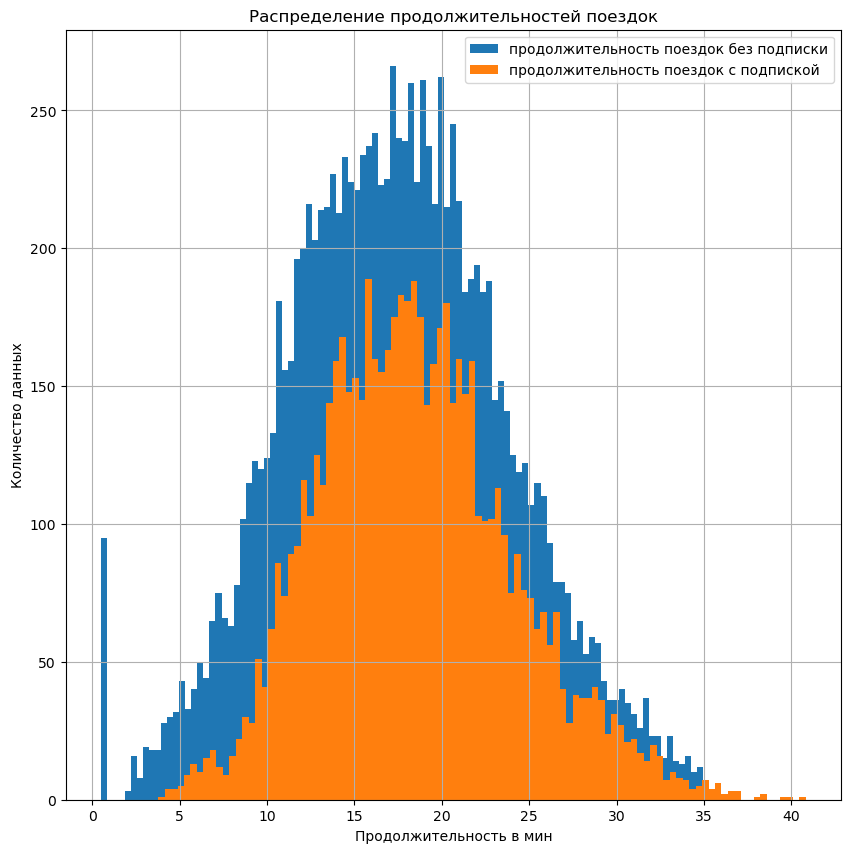

In [46]:
(
    total_free['duration']
    .plot
    (
        kind = 'hist',
        grid=True,
        figsize=(10,10),
        bins = 100,
        title = 'Распределение продолжительностей поездок',
        legend = True
    )
)
(
    total_ultra['duration']
    .plot(kind = 'hist', grid=True, figsize=(10,10), bins = 100, legend = True)
)
plt.legend(['продолжительность поездок без подписки', 'продолжительность поездок с подпиской'])
plt.ylabel('Количество данных')
plt.xlabel('Продолжительность в мин')
plt.show()

По гистограмме видим нормальное распределение продолжительности поездок в обоих случаях - с подпиской и без. Т.к. пользователей по нашим данным с подпиской меньше, то оранжевая гистограмма лежит ниже. Также видим, что центр распределения у обоих гистограмм примерно совпадает.

И построим такую же гистограмму с распределением расстояний (с подпиской и без):

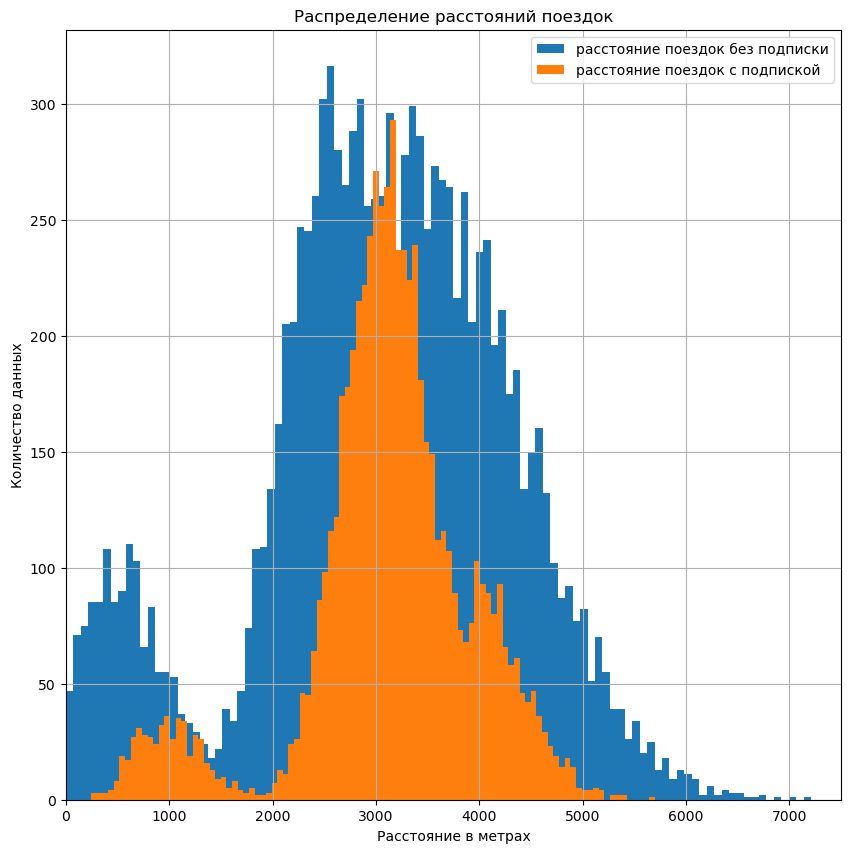

In [47]:
(
    total_free['distance']
    .plot
    (
        kind = 'hist',
        grid=True,
        figsize=(10,10),
        bins = 100,
        title = 'Распределение расстояний поездок',
        legend = True
    )
)
(
    total_ultra['distance']
    .plot(kind = 'hist', grid=True, figsize=(10,10), bins = 100, legend = True)
)
plt.legend(['расстояние поездок без подписки', 'расстояние поездок с подпиской'])
plt.ylabel('Количество данных')
plt.xlabel('Расстояние в метрах')
plt.xlim(0,7500)
plt.show();

По гистограмме видим нормальное распределение расстояний поездок в обоих случаях - с подпиской и без. Т.к. пользователей по нашим данным с подпиской меньше, то оранжевая гистограмма лежит ниже. Также видим, что центр распределения у обоих гистограмм примерно совпадает. И у обоих гистограмм есть второй (меньший) пик распределения - у синей - в районе 500 м, у оранжевой - в районе 1000 м. 

*Итак, в шаге 4 мы объединили данные:*

* объединили три сиходных датафрейма в один
* создали два датафрейма: c данными о пользователях без подписки и с данными о пользователях с подпиской
* и визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий

#### Шаг 5. Подсчёт выручки

##### Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

Сначала добавим столбец в таблицу с округленным значением расстояния до следующего целого значения. И создаем  сводную таблицу с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц. Также в таблицу добавляем необходимые столбцы для последующего расчета выручки.

In [48]:
total_df['duration_ceil'] = np.ceil(total_df['duration']) 
agg_total_df = total_df.pivot_table(
    index=['user_id', 'month'],
    values=['distance', 'duration', 'duration_ceil', 'minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type'],
    aggfunc={'distance': 'sum', 'duration': 'count', 'duration_ceil': 'sum', 'minute_price': 'first', 'start_ride_price': 'first', 'subscription_fee': 'first', 'subscription_type': 'first'})

agg_total_df.columns = ['total_distance', 'rides_amount', 'total_duration', 'minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type']
agg_total_df.head(10)

total_distance  rides_amount  total_duration  minute_price  \
user_id month                                                               
1       1         7027.511294             2            42.0             6   
        4          754.159807             1             7.0             6   
        8         6723.470560             2            46.0             6   
        10        5809.911100             2            32.0             6   
        11        7003.499363             3            56.0             6   
        12        6751.629942             2            28.0             6   
2       3        10187.723006             3            63.0             6   
        4         6164.381824             2            40.0             6   
        6         3255.338202             1            14.0             6   
        7         6780.722964             2            48.0             6   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra  
        12                    0               199             ultra  
2       3                     0               199             ultra  
        4                     0               199             ultra  
        6                     0               199             ultra  
        7                     0               199             ultra

##### В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки.

Помесячная выручка считается по формуле: (стоимость старта поездки * количество поездок) + (стоимость одной минуты поездки * общая продолжительность всех поездок в минутах) +  стоимость подписки. Создадим функцию для подсчета и добавим столбец с помощью этой функции:

In [49]:
def revenue(row):
    return row['start_ride_price'] * row['rides_amount'] + row['minute_price'] * row['total_duration'] + row['subscription_fee']
agg_total_df['month_revenue'] = agg_total_df.apply(revenue, axis=1)

In [50]:
agg_total_df.head()

total_distance  rides_amount  total_duration  minute_price  \
user_id month                                                               
1       1         7027.511294             2            42.0             6   
        4          754.159807             1             7.0             6   
        8         6723.470560             2            46.0             6   
        10        5809.911100             2            32.0             6   
        11        7003.499363             3            56.0             6   

               start_ride_price  subscription_fee subscription_type  \
user_id month                                                         
1       1                     0               199             ultra   
        4                     0               199             ultra   
        8                     0               199             ultra   
        10                    0               199             ultra   
        11                    0               199             ultra   

               month_revenue  
user_id month                 
1       1              451.0  
        4              241.0  
        8              475.0  
        10             391.0  
        11             535.0

*Итак, в шаге 5 мы подсчитали выручку по каждому пользователю и по месяцам.*

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

##### Продолжительность поездок
Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Вспомним исходные датафреймы - для подписчиков и для пользователей без подписок:

In [51]:
total_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [52]:
total_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Будем проверять правостороннюю гипотезу с двумя независимыми выборками (датафреймами) о том, что пользователи с подпиской тратят больше времени на поездку. Для этого нам потребуются столбцы duration. Распределение по продолжительности поездок мы строили ранее в п.4.3 - они имеют нормальный характер распределения. Количество выборок в двух датафреймах разные. Поэтому дисперсии у них могут отличаться - учтем это в коде для t-теста.

Итак, нулевая гипотеза - средние значения продолжительности поездок с подпиской и без равны. Альтернативная - средние значения продолжительности поездок с подпиской больше.

In [53]:
free = total_free['duration']
ultra = total_ultra['duration']

alpha = 0.05 #уровень значимости 5%

results = st.ttest_ind(ultra, free, equal_var=False, alternative='greater')
print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


Значение вероятности гораздо меньше допустимого уровня значимости - значит, есть полное (практически 100%-ное) основание говорить, что продолжительность поездок с подпиской больше, чем без подписки.

##### Расстояние одной поездки
Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу и сделаем выводы.

Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 м

Альтернативная гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку больше 3130 м

In [54]:
ultra_distance = total_ultra['distance']

optimal_value = 3130

alpha = 0.05  #уровень значимости 5%

results = st.ttest_1samp(
    ultra_distance, 
    optimal_value,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Получили значение вероятности почти 92% - значит, с этой вероятностью мы можем считать, что поездки не превышают расстояние в 3130 м.

##### Выручка с подпиской и без
Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделаем вывод.

Нулевая гипотеза: помесячная выручка от пользователей с подпиской равна выручке от пользователей без подписки.

Альтернативная: помесячная выручка от пользователей с подпиской выше выручки от пользователей без подписки.

In [55]:
agg_total_df.head()

total_distance  rides_amount  total_duration  minute_price  \
user_id month                                                               
1       1         7027.511294             2            42.0             6   
        4          754.159807             1             7.0             6   
        8         6723.470560             2            46.0             6   
        10        5809.911100             2            32.0             6   
        11        7003.499363             3            56.0             6   

               start_ride_price  subscription_fee subscription_type  \
user_id month                                                         
1       1                     0               199             ultra   
        4                     0               199             ultra   
        8                     0               199             ultra   
        10                    0               199             ultra   
        11                    0               199             ultra   

               month_revenue  
user_id month                 
1       1              451.0  
        4              241.0  
        8              475.0  
        10             391.0  
        11             535.0

In [56]:
ultra_revenue = agg_total_df.query('subscription_type == "ultra"')['month_revenue']
free_revenue = agg_total_df.query('subscription_type == "free"')['month_revenue']

alpha = 0.05 #уровень значимости 5%

results = st.ttest_ind(ultra_revenue, free_revenue, equal_var=False, alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Итак, значение вероятности нулевой гипотезы настолько малое, что можно практически со 100% вероятностью считать, что помесячная выручка от пользователей с подпиской выше выручки от пользователей без подписки.

##### Количество обращений в техподдержку
Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

В данном случае нам нужна гипотеза о равенстве средних для зависимых (парных) выборок. Для этого используется тест scipy.stats.ttest_rel(before, after). Ему достаточно передать всего два параметра: наборы данных до и после. Оба набора должны быть одинаковыми по размеру: каждое измерение должно быть проведено до и после изменения. А также порядок объектов, для которых сделаны измерения, в обоих массивах тоже должен быть одинаковый.

Нулевая гипотеза: количество обращений в техподдержку не изменилось

Альтернативная гипотеза: количество обращений в техподдержку значимо снизилось

*Итак, по шагу 6 проверены 3 гипотезы и выдвинута 1 гипотеза без ее проверки.*

#### Выводы по проекту

Итак, в ходе проекта были проанализированы данные о некоторых пользователях из нескольких городов, а также об их поездках сервиса аренды самокатов GoFast. 

Были выполнены: предобработка данных, исследовательский анализ данных, объединение данных, подсчет выручки, проверка гипотез.

##### Проведенный исследовательский анализ данных:

Предоставим некоторые полученные **графики** для наглядности:

1. График частоты встречаемости городов

На графике частота втречаемости городов расположена по возрастанию. Видим, что в Москве самое маленькое кол-во пользователей самокатов (примерно 170 пользователей). В Пятигорске - самое высокое!(больше 200).
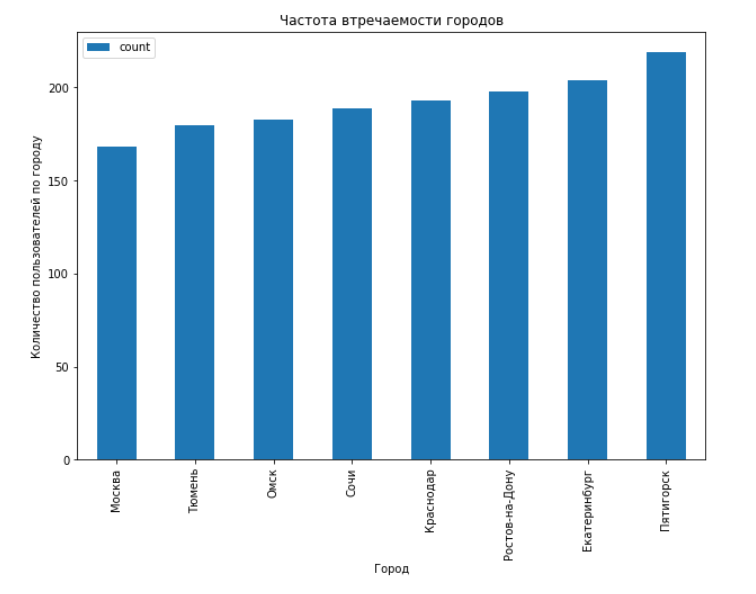

2. Cоотношение пользователей с подпиской и без подписки

Пользователей без подписки больше половины. Их доля составляет 54,4% тогда как пользователи с подпиской - 45,6% 

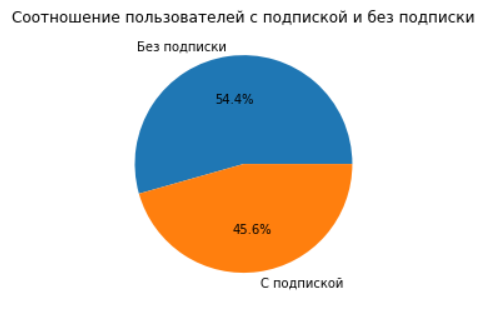

3. Возраст пользователей

Получилось нормальное распределение от 12 до 43 лет с центром распределения 25 лет, без выбросов и аномалий, с плавным снижением пользователей с возрастом менее и более 25 лет. Половина пользователей, находящихся вокруг среднего возраста (межквартильный размах) имеет возраст от 22 до 28 лет.


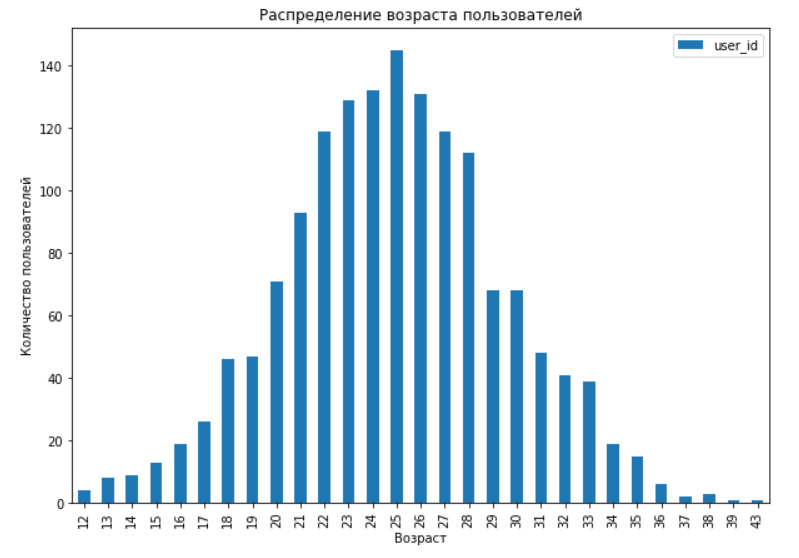

4. Расстояние, которое пользователь преодолел за одну поездку

Распределение расстояний нормальное от 0 до 7500 м. с центром значений около 3000 м. Но также есть небольшой пик с нормальным распределением примерно на 700 м.

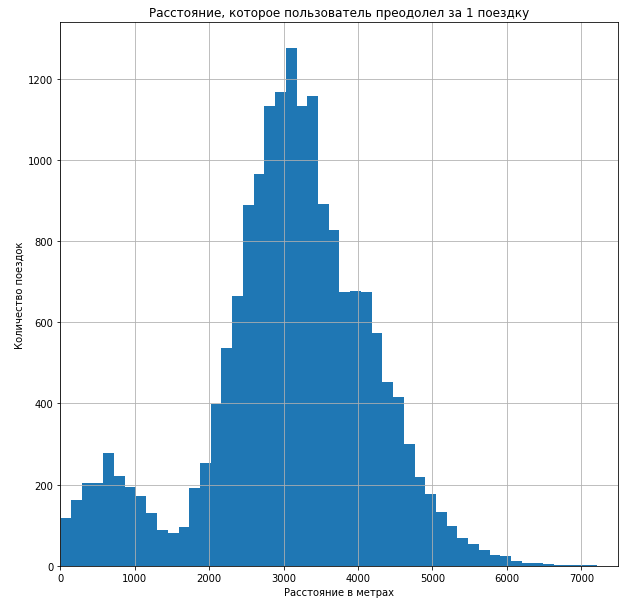

5. Продолжительность поездок

Нормальное распределение от 2 до 42 мин, максимальное кол-во поездок занимает 17-18 мин. Межквартильный размах данных составляет от 13,6 мин до 21,7 мин.

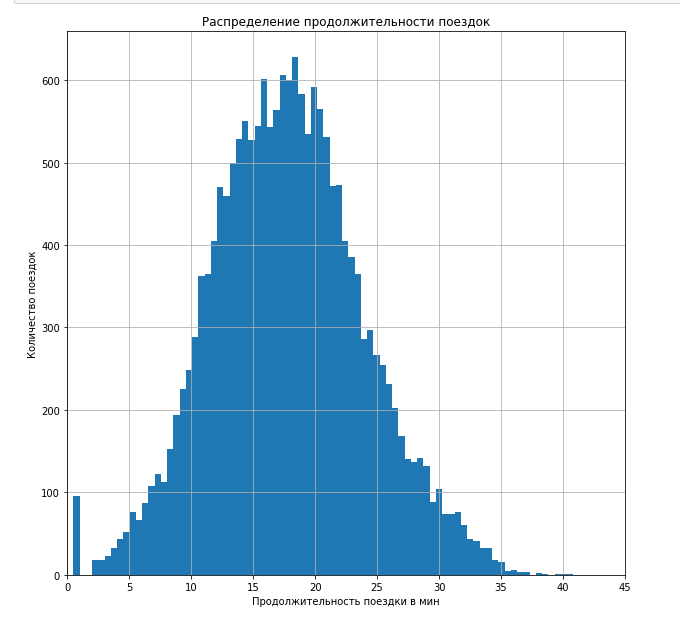

##### Визуализация о расстоянии и времени поездок для пользователей обеих категорий

**График распределения продолжительности поездок с подпиской и без подписки**

По гистограмме видим нормальное распределение продолжительности поездок в обоих случаях - с подпиской и без. Т.к. пользователей по нашим данным с подпиской меньше, то оранжевая гистограмма лежит ниже. Также видим, что центр распределения у обоих гистограмм примерно совпадает и равен 17 мин


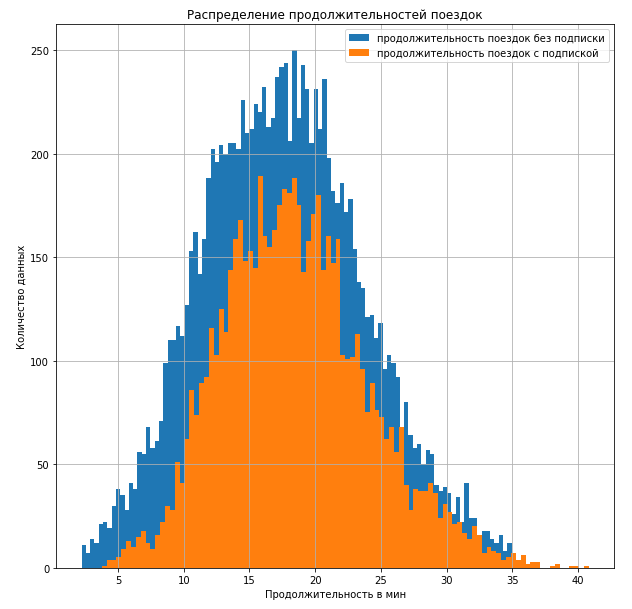

**График распределения расстояний поездок с подпиской и без подписки**

По гистограмме видим нормальное распределение расстояний поездок в обоих случаях - с подпиской и без. Т.к. пользователей по нашим данным с подпиской меньше, то оранжевая гистограмма лежит ниже. Также видим, что центр распределения у обоих гистограмм примерно совпадает и равен около 3000 м. И у обоих гистограмм есть второй (меньший) пик распределения - у синей - в районе 500 м, у оранжевой - в районе 1000 м.

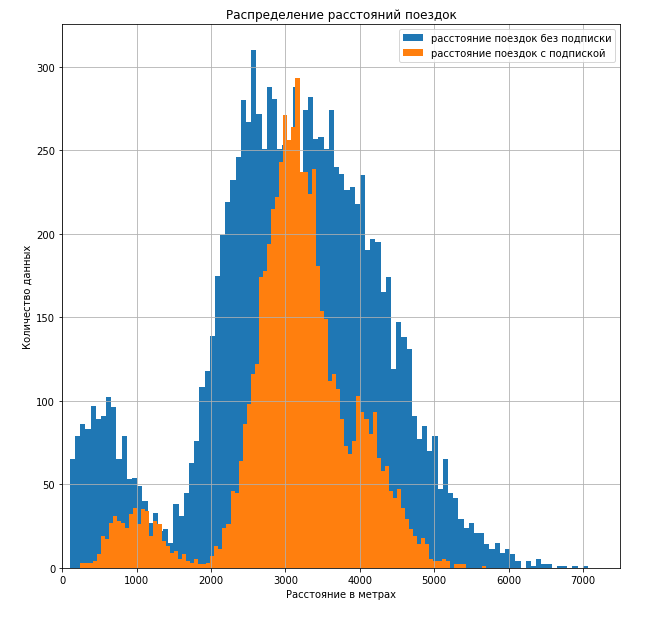

##### Проверка гипотез

###### О продолжительности поездок с подпиской и без
Тратят ли пользователи с подпиской больше времени на поездки?

Есть значительная (почти 100%-ная) вероятность считать, что продолжительность поездок с подпиской больше, чем без подписки.

###### Расстояние одной поездки

Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Получили значение вероятности почти 92% - с этой вероятностью можно считать, что в среднем поездки не превышают расстояние в 3130 м.

###### Выручка с подпиской и без

Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Можно практически со 100% вероятностью считать, что помесячная выручка от пользователей с подпиской выше выручки от пользователей без подписки.

**Рекомендации заказчику**

Итак, в предоставленных данных больше пользователей самокатов без подписки, но по результатам проведенного анализа и по результатам проверки выдвинутых гипотез можно рекомендовать рекламному отделу продвигать услугу использования самокатов с подпиской, т.к. этот вариант, вероятнее всего, экономически выгоднее для бизнеса.

#### Шаг 7. Распределения

##### Количество промокодов
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Нам нужно найти вероятность не конкретного значения, а «хвоста» распределения, в данном случае нас интересует, что мы получим не менее 100 подписок. Поэтому будем применять аппроксимацию биномиального распределения нормальным распределением и метод cdf().

Сначала построю график биномиального распределения с известной веротяностью 0.1 (т.к. 10% пользователей продлевали подписку), минимальное количество промокодов, которое нужно разослать - нам неизвестно и нужно найти. Подберем примерно такое значение, чтобы центр распределения оказался на значении 100 (по оси x).

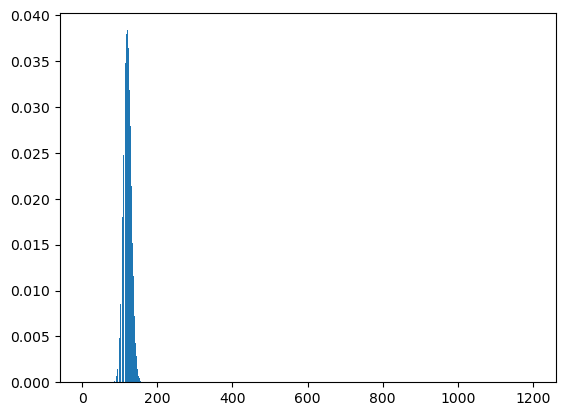

In [57]:
n = 1200 # пусть количество попыток=1200
p = 0.10 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr);

Вижу, что центр значений как раз находится примерно на 100 из 1200 попыток. 

Теперь аппроксимируем это распределение нормальным и подберем количество попыток n (минимальное количество промокодов) более точно, учитывая, что вероятность не выполнить план длолжна быть примерно 5 %.

In [58]:
from math import sqrt
from scipy import stats as st

# задаём параметры биномиального распределения
n = 1170 #подобранное опытным путем значение
p = 0.1 #известная вероятность

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 100
result = distr.cdf(100)
print('Вероятность получить менее 100 подписок составляет', result)

Вероятность получить менее 100 подписок составляет 0.04879359652776027


Итого, необходимо разослать минимум 1170 промокодов., чтобы получить не менее 100 подписок с вероятностью 95%.

##### push-уведомления
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

С помощью аппроксимации нормальным распределением и методом cdf() рассчитаем вероятность того, что уведомление откроют не более 399,5 тыс. пользователей при количестве разосланных уведомлений = 1 млн. и вероятности их открытия = 0.4

In [59]:
# задаём параметры биномиального распределения
n = 1000000 
p = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399501
result = distr.cdf(399501)
print('Вероятность, что уведомления откроют не более 399,5 тыс пользователей, составляет', result)

Вероятность, что уведомления откроют не более 399,5 тыс пользователей, составляет 0.15420132397643166


Итак, вероятность, что уведомления откроют не более 399,5 тыс пользователей, составляет 15,4%.

Теперь построим биномиальное распределение с помощью аппроксимации нормальным распределением:

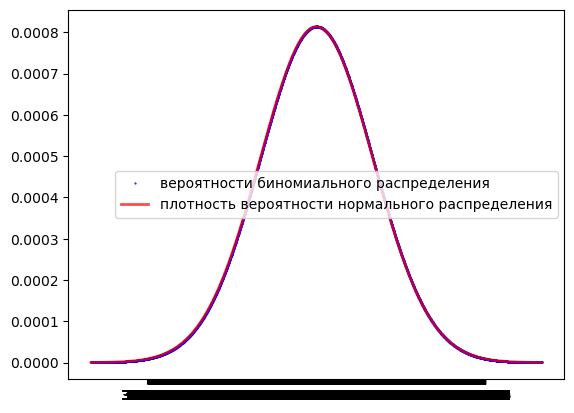

In [60]:
# зададим функцию, которая выдаёт <num> чисел,
# равномерно распределённых от <start> до <stop>
# (понадобится для визуализации нормального распределения)
def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# границы промежутка, в котором будем строить аппроксимацию -
# от n*p минус 4 ст.отклонения бином.распределения
# до n*p плюс 4 ст.отклонения бином.распределения
# (там, где вероятности значений почти не равны нулю)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot()
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=0.5, label='вероятности биномиального распределения')

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 
# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=2, alpha=0.7, label='плотность вероятности нормального распределения')
 
# зададим подписи по оси x в пределах ± 3 ст.отклонений от мат.ожидания
# (последний аргумент в методе range - интервал между подписями)
x_ticks = list(range(int(mu - 3 * sigma), int(mu + 3 * sigma), 1))
ax.set_xticks(x_ticks)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(loc='best')
plt.show()